In [1]:
#Setup for linearization

In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import pandas as pd
import sympy as sy
from sympy.solvers import solve
from collections import namedtuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

In [3]:
params = ["a", "alpha", "delta","beta",  "gamma", "rho", "sigma", "tau", "zbar", "xi"]
pill = namedtuple("pill", params)
m = pill(0.50, 0.40, 0.10, 0.98, 2.50, 0.95, 0.02, 0.05, 0, 1.5)

In [4]:
## The Euler Equation

def euler_eqn(m, x):
    l = 1 #(Initialize)
    k = x
    w = (1 - m.alpha) * np.exp(m.zbar) * ((k / np.exp(m.zbar)) ** m.alpha)
    r = m.alpha * ((np.exp(m.zbar) / k) ** (1 - m.alpha))
    T = m.tau * (w + (r - m.delta)* k)
    c = (1 - m.tau) * (w + (r - m.delta)* k) + k + T - k
    euler = 1/(c ** m.gamma) - (m.beta / (c ** m.gamma)) * ((r - m.delta) * (1 - m.tau) + 1)
    return euler

## The Solver
    
def solve_ss(m):
    solve_me = lambda x: euler_eqn(m, x)
    sol = opt.root(solve_me, .5)
    
    return sol.x

In [5]:
kbar = solve_ss(m)
rbar = m.alpha * ((np.exp(m.zbar) / kbar) ** (1 - m.alpha))
wbar = (1 - m.alpha) * np.exp(m.zbar) * ((kbar / np.exp(m.zbar)) ** m.alpha)
Tbar = m.tau * (wbar + (rbar - m.delta)* kbar)
cbar = (1 - m.tau) * (wbar + (rbar - m.delta)* kbar) + Tbar

Ybar = kbar ** m.alpha * np.exp(m.zbar) ** (1 - m.alpha)
ibar = m.delta * kbar

SS_vals = {'Kbar': kbar, 'cbar': cbar, 'wbar': wbar, 'ibar': ibar, 'rbar': rbar, 'Tbar': Tbar, 
           'Ybar': Ybar}

print(SS_vals)

{'Kbar': array([7.28749795]), 'cbar': array([1.48450482]), 'wbar': array([1.32795277]), 'ibar': array([0.7287498]), 'rbar': array([0.12148228]), 'Tbar': array([0.07422524]), 'Ybar': array([2.21325461])}


In [6]:
ralg = (1 - m.beta) / (m.beta * (1 - m.tau)) + m.delta
kalg = (ralg / m.alpha) ** (1 / (m.alpha - 1))
walg = (1 - m.alpha) * (kalg) ** m.alpha
Talg = m.tau * (walg + (ralg - m.delta)* kalg)
calg = (1 - m.tau) * (walg + (ralg - m.delta)* kalg) + Talg
Yalg = kalg ** m.alpha * np.exp(m.zbar) ** (1 - m.alpha)
ialg = m.delta * kalg

SS_vals_alg = {'Kbar': kalg, 'cbar': calg, 
               'rbar': ralg, 'Tbar': Talg, 'wbar': walg,
               'Ybar': Yalg, 'ibar': ialg}

print(SS_vals_alg)

{'Kbar': 7.287497950692988, 'cbar': 1.484504818849544, 'rbar': 0.1214822771213749, 'Tbar': 0.0742252409424772, 'wbar': 1.3279527683513057, 'Ybar': 2.213254613918843, 'ibar': 0.7287497950692988}


In [7]:
pd.DataFrame(SS_vals_alg, SS_vals)

,Kbar,cbar,rbar,Tbar,wbar,Ybar,ibar
Kbar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875
cbar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875
wbar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875
ibar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875
rbar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875
Tbar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875
Ybar,7.287498,1.484505,0.121482,0.074225,1.327953,2.213255,0.72875


In [8]:
def u(m, c, l):
    uc = (c**(1.0 - m.gamma) - 1.0) / (1.0 - m.gamma)
    ul = m.a * ((1.0 - l)**(1.0 - m.xi) - 1.0) / (1.0 - m.xi)
    return uc + ul

def du_dl(m, c, l):
    return - m.a * (1.0 - l)**(-m.xi)

def du_dc(m, c, l):
    return c**(-m.gamma)

def f(m, k, l, z):
    return k**m.alpha * (l * np.exp(z))**(1.0 - m.alpha)

def df_dk(m, k, l, z):
    return m.alpha * (l/k * np.exp(z))**(1.0 - m.alpha)

def df_dl(m, k, l, z):
    return (1.0 - m.alpha) * np.exp(z)**(1.0 - m.alpha) * (k / l)**m.alpha

In [9]:
def bas(m, ktp1, kt, lt, zt):
    wt = df_dl(m, kt, lt, zt)
    rt = df_dk(m, kt, lt, zt)
    Tt = m.tau * (wt*lt + (rt - m.delta)*kt)
    ct = (1 - m.tau) * (wt*lt + (rt - m.delta)*kt) + kt + Tt - ktp1 
    return ct, rt, Tt, wt


def CE(m, ktp2, ltp1, ktp1, lt, kt, ltm1, ztp1, zt):
    ct, rt, Tt, wt = bas(m, ktp1, kt, lt, zt)
    ctp1, rtp1, Ttp1, wtp1 = bas(m, ktp2, ktp1, ltp1, ztp1)
    rr_tp1 = (rtp1 - m.delta)*(1 - m.tau) + 1.0

    inter_ee = du_dc(m, ct, lt) - m.beta*du_dc(m, ctp1, ltp1)*rr_tp1
    intra_ee = du_dl(m, ct, lt) + du_dc(m, ct, lt)*wt*(1.0 - m.tau)

    return np.array([inter_ee, intra_ee])

In [10]:
def solve_ss(m):
    solve_me = lambda x: CE(m, x[0], x[1], x[0], x[1], x[0], x[1], 0.0, 0.0)
    sol = opt.root(solve_me, np.array([0.5, 0.85]))

    return sol.x

In [11]:
kbar, lbar = solve_ss(m)
cbar, rbar, Tbar, wbar = bas(m, kbar, kbar, lbar, 0.0)
Ybar = kbar ** m.alpha * np.exp(m.zbar) ** (1 - m.alpha)
ibar = m.delta * kbar

SS_vals = {'Kbar': kbar, 'Lbar': lbar, 'wbar': wbar,'Ybar': Ybar, 'ibar': ibar, 'cbar': cbar, 'rbar': rbar, 'Tbar': Tbar}

print(SS_vals)

{'Kbar': 4.225229026815977, 'Lbar': 0.5797914531671479, 'wbar': 1.3279527683552124, 'Ybar': 1.7796725500732373, 'ibar': 0.4225229026815977, 'cbar': 0.8607032061550788, 'rbar': 0.12148227712083877, 'Tbar': 0.04303516030775391}


# Linearization Methods

## Exercise 1

{'F': 3.070711692755581, 'G': -9.061732872907285, 'H': -0.644736842105263, 'N': 0.95, 'M': 1.6447368421052628, 'P': 0.4, 'Q': 0.20996332662109748}


C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


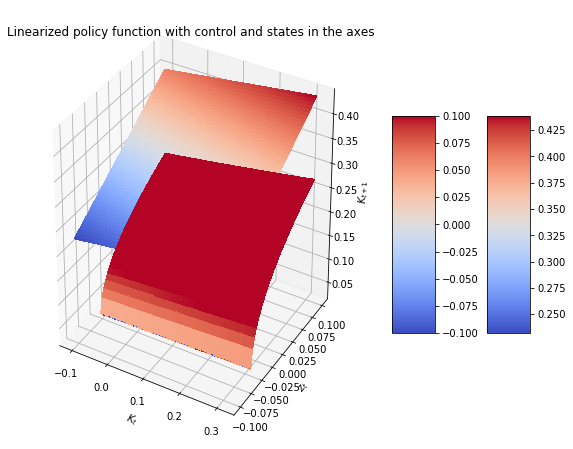

In [12]:
A = m.alpha * m.beta
Kbar = A ** (1 / (1 - m.alpha))
N = m.rho
F = (m.alpha * m.beta * Kbar ** (m.alpha - 1)) / (Kbar ** m.alpha - Kbar)
H = F * m.alpha * (Kbar ** (m.alpha - 1))
M = F * (Kbar ** m.alpha)
L = - F * Kbar
G = - F * (m.alpha + Kbar ** (m.alpha - 1))
P1 = (-G - np.sqrt(G ** 2 - 4 * F * H)) / (2 * F)
Q1 = - (L*N + M) / (F*N + F*P1 + G)

Vals = {"F": F, "G": G, "H": L, "N": N, "M": M, "P": P1, "Q": Q1}
print(Vals)

n = 100
Kmin = -0.5 * Kbar
Kmax =  1.5 * Kbar   # Grid for K
Zmin = -5 * m.sigma
Zmax = 5 * m.sigma
Zgrid = np.linspace(Zmax, Zmin, n)
Kgrid = np.linspace(Kmax, Kmin, n)
K, Z = np.meshgrid(Kgrid, Zgrid)

def pf_uhlig(K, Kbar, P, Q, z):
    return Kbar + P * (K + Kbar) + Q*z

policy1 = np.zeros((n, n))
for i in range(n):
    policy1[i,:] = pf_uhlig(Kgrid[i], Kbar, P1, Q1, Zgrid)

def pf(A, z, K, alpha):
    return A * np.exp(z) * K ** alpha

policy2 = np.zeros((n, n))
for i in range(n):
    policy2[i,:] = pf(A, Zgrid, Kgrid[i], m.alpha)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt1 = ax.plot_surface(K, Z, policy1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt2 = ax.plot_surface(K, Z, policy2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title('Linearized policy function with control and states in the axes')
ax.set_zlabel(r'$K_{t+1}$')
ax.set_xlabel(r'$K_t$')
ax.set_ylabel(r'$z_t$')
fig.colorbar(plt1, shrink=0.5, aspect=5)
fig.colorbar(plt2, shrink=0.5, aspect=5)

plt.show()

In [13]:
Kbar

0.20996332662109743

## Exercise 2

In [14]:
def Modeldyn_2(theta, params):
    
    #Serial unpacking and exponentiate
    alpha, beta = params
    (K2, K1, K, Z1, Z) = theta
    K2 = np.exp(K2)
    K1 = np.exp(K1)
    K = np.exp(K)
    Z1 = np.exp(Z1)
    Z = np.exp(Z)
    
    # Evaluate Euler equations
    Euler = (beta * ((alpha * Z1 * K1 ** (alpha - 1)) * (Z * K ** alpha - K1))) / ((Z1 * K1 ** alpha - K2)) 
    
    return Euler

In [15]:
#The parameter and lin-app 
alpha = .35
beta = .98
params = (alpha, beta)
Zbar = np.array([0.])
nx = 1
ny = 0
nz = 1
logX = 1
Sylv = 0
rho = .95
NN = rho
Kbar = (alpha * beta) ** (1.0 / (1 - alpha))
theta = np.array([Kbar, Kbar, Kbar, 0., 0.])


In [16]:
# matrix computatation and sylvester condition
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn_2, params, theta, nx, ny, nz, logX)
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM) 
print ('PP:',PP)
print ('QQ:', QQ)

FF:  [[-0.38025431]]
GG:  [[0.46855868]]
HH:  [[-0.11741439]]
LL:  [[2.56932087]]
MM:  [[-2.26671785]]
PP: [[0.35]]
QQ: [[6.75684857]]


In [17]:
# Create grid for K and Z
Kmax = 2.5 * Kbar
Kmin = -1.5 * Kbar
n = 50
Kgrid = np.linspace(Kmax, Kmin, n)
Zmin = -3 * m.sigma
Zmax = 3 * m.sigma
Zgrid = np.linspace(Zmax, Zmin, n)
K, Z = np.meshgrid(Kgrid, Zgrid)

def pf_uhlig_1(K, Kbar, P, Q, z):
    return Kbar + P * (K + Kbar) + Q*z

policy1 = np.zeros((n, n))

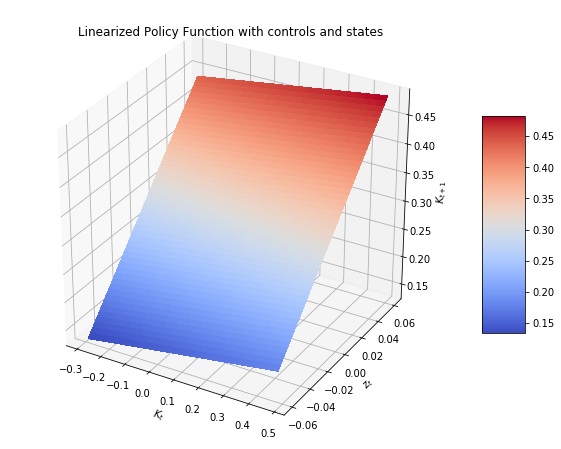

In [18]:
for i in range(n):
    policy1[i,:] = pf_uhlig_1(Kgrid[i], Kbar, P1, P1, Zgrid)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, Z, policy1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('Linearized Policy Function with controls and states')
ax.set_ylabel(r'$z_t$')
ax.set_zlabel(r'$K_{t+1}$')
ax.set_xlabel(r'$K_t$')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

   ## Exercise 4

In [19]:
# Again define
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
rho_z = 0.9
tau = 0.05
a = 0.5
delta = 0.10
z_bar = 0

params = gamma, xi, beta, alpha, a, delta, z_bar, tau

In [20]:
def Modeldefs(Xp, X, Y, Z, params):
    kp = Xp
    k = X
    l = Y
    z = Z
    
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    Y = (k ** alpha)*(((np.exp(z) * l)**(1 - alpha)))
    w = (1 - alpha)* np.exp(z) * ((k /( l * np.exp(z))) ** alpha)
    r = alpha *((l * np.exp(z) / k)**(1 - alpha))
    T = tau * (w * l + (r - delta) * k)
    c = (1 - tau) * (w * l +(r - delta) * k)+ k + T - kp
    u = (c ** (1 - gamma) - 1)/(1 - gamma) + a * (((1 - l) ** (1 - xi)) - 1)/(1 - xi)
    return Y, w, r, c, u

In [21]:
def Modeldyn(theta0, params):
    
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    l = Y 
    
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    Y, w, r, c, u = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    E1 = (c**(-gamma))-beta*(cp**(-gamma))*((1-tau)*(rp-delta)+1)
    E2 = a*((1-l)**(-xi))-w*(1-tau)*(c**(-gamma))
    
    return np.array([E1, E2])

In [22]:
Zbar = np.array([z_bar])
nx = 1
ny = 1
nz = 1
logX = 0
Sylv = 0

In [23]:
# Guess 
guess = np.array([5, .3])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guess, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
Ybar, wbar, rbar, cbar, ubar = Modeldefs(kbar, kbar, ellbar, 0, params)
Tbar, ibar = tau*cbar, delta*kbar
print ('Ybar: ', Ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
print ('Tbar: ', Tbar)
print ('ibar: ', ibar)

XYbar:  [4.22522903 0.57979145]
check:  [5.81756865e-14 1.23634436e-12]
Ybar:  1.283226108833101
wbar:  1.3279527683516184
rbar:  0.121482277121332
cbar:  0.8607032061543958
ubar:  -0.7108726381176589
Tbar:  0.04303516030771979
ibar:  0.42252290267870507


## Exercise 5

In [24]:
eps = 1e-5

steady_states = np.array(['kss', 'css', 'rss', 'wss', 'lss', 'Tss', 'yss', 'iss'])
parameters = np.array(['gamma', 'xi', 'beta', 'alpha', 'a', 'delta', 'z_bar', 'tau'])

Derivative_Mat = np.zeros((len(steady_states), len(parameters)))

params = np.array([gamma, xi, beta, alpha, a, delta, z_bar, tau])

In [25]:
for index, param in enumerate(params):
    # Find central difference
    paramplus1 = param + eps
    paramminus1 = param - eps
    params_plus1 = np.copy(params)
    params_minus1 = np.copy(params)
    params_plus1[index] = paramplus1
    params_minus1[index] = paramminus1

    if index == 6:
        Zbar1 = np.array([paramplus1])
        Zbar2 = np.array([paramminus1])
    else:
        Zbar1 = np.array([0])
        Zbar2 = np.array([0])
        
    XYbarplus1 = LinApp_FindSS(Modeldyn, params_plus1, guess, Zbar1, nx, ny)
    (kbarplus1, ellbarplus1) = XYbarplus1
    yplus1, wplus1, rplus1, cplus1, uplus1 = Modeldefs(kbarplus1, kbarplus1, ellbarplus1, 0, params_plus1)
    Tplus1, iplus1 = params_plus1[7]*cplus1, params_plus1[5]*kbarplus1
    
    XYbarminus1 = LinApp_FindSS(Modeldyn, params_minus1, guess, Zbar2, nx, ny)
    (kbarminus1, ellbarminus1) = XYbarminus1
    yminus1, wminus1, rminus1, cminus1, uminus1 = Modeldefs(kbarminus1, kbarminus1, ellbarminus1, 0, params_minus1)
    Tminus1, iminus1 = params_minus1[7]*cminus1, params_minus1[5]*kbarminus1

    vals = np.array([kbarplus1 - kbarminus1, cplus1 - cminus1,
                     rplus1 - rminus1, wplus1 - wminus1,
                     ellbarplus1 - ellbarminus1, Tplus1 - Tminus1,
                     yplus1 - yminus1, iplus1 - iminus1])
    
    Derivative_Mat[:, index] = vals / (2 * eps)

In [26]:
display_derivatives = pd.DataFrame(data = Derivative_Mat, index=steady_states, columns=parameters)
print(display_derivatives.round(decimals=4))

      gamma      xi     beta    alpha       a    delta   z_bar     tau
kss  0.1387 -0.8017  65.4304  25.9849 -1.8493 -48.3498  2.8383 -2.3232
css  0.0283 -0.1633   1.7511   2.0852 -0.3767  -3.5113 -0.1918 -0.2344
rss  0.0000  0.0000  -1.0960  -0.0000  0.0000   1.0000 -0.0729  0.0226
wss -0.0000  0.0000   7.9873   4.3959 -0.0000  -7.2875  0.5312 -0.1648
lss  0.0190 -0.1100   0.2602  -0.7694 -0.2538   1.3198 -0.1903 -0.1389
Tss  0.0014 -0.0082   0.0876   0.1043 -0.0188  -0.1756 -0.0096  0.8490
yss  0.0421 -0.2435   8.2941   4.6837 -0.5616  -4.1210  0.0921 -0.4667
iss  0.0139 -0.0802   6.5430   2.5985 -0.1849  -0.6098  0.2838 -0.2323


## Exercise 6 (DEFINE)

In [27]:
# set value for NN    
NN = rho_z
def Modeldyn_6(theta0, params):
    
    
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    
    
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    
    Y, w, r, c, u = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    
    ell = Y
    E1 = (c**(-gamma)*w) / (chi*ell**theta) - 1
    E2 = (c**(-gamma)) / (beta*cp**(-gamma)*(1 + rp - delta)) - 1
    
    return np.array([E1, E2])

In [28]:
def Modeldyn2(theta0, params):
   
    
    # unpack theta0
    (Kpp, lp, Kp, l, K, lminus1, Zp, Z) = theta0
    
    # unpack parameters
    gamma, xi, beta, alpha, a, delta, z_bar, tau = params
    
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs(Kp, K, l, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Kpp, Kp, lp, Zp, params)
    
    # Evaluate Euler equations
    E1 = (c**(-gamma))-beta*(cp**(-gamma))*((1-tau)*(rp-delta)+1)
    E2 = a*((1-l)**(-xi))-w*(1-tau)*(c**(-gamma))
    
    return np.array([E1, E2])

In [29]:
nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 0

# set up steady state input vector
theta0 = np.array([kbar, ellbar, kbar, ellbar, kbar, ellbar, 0., 0.])

# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn2, params, theta0, nx, ny, nz, logX)
np.set_printoptions(suppress=False)
np.set_printoptions(precision=7)

PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP, 'QQ:', QQ, 'FF: ', FF, 'GG: ', GG, 'HH: ', HH, 'LL: ', LL, 'MM: ', MM)
    

PP: [[ 0.9152937  0.       ]
 [-0.191927   0.       ]] QQ: [[ 0.1289971]
 [-0.0113101]] FF:  [[-17.8567859   3.1551874]
 [  0.          0.       ]] GG:  [[ 36.1959133  -3.2539245]
 [-22.5273198   8.6382499]] HH:  [[-18.2403903   0.       ]
 [ 22.277027    0.       ]] LL:  [[3.1551874]
 [0.       ]] MM:  [[-3.2539245]
 [ 3.0036588]]


## Exercise 7

In [30]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
delta = 0.10
rho_z = 0.9
tau = 0.05
alpha = 0.4
a = 0.5
mu_z = 0
numPeriods = 250
sigma_z = 0.02
numSims = 10000

GDP = np.zeros((numSims, numPeriods))
consumption = np.zeros((numSims, numPeriods))
investment = np.zeros((numSims, numPeriods))
laborInc = np.zeros((numSims, numPeriods))

X_bar = np.array([[kbar],[ellbar]])
Z_bar = 0

for i in range(numSims):
    Z_tilde = np.zeros(numPeriods + 1)
    X_tilde = np.zeros((2,numPeriods + 1))
    eps = np.random.normal(loc=mu_z, scale=sigma_z, size=numPeriods)
    
    for t in range(1, numPeriods + 1):
        Z_tilde[t] = NN * (Z_tilde[t-1]) + eps[t-1]
        X_t_minus1 = np.array([X_tilde[:,t-1]]).T
        X_tilde[:,t] = (np.dot(PP, X_t_minus1) + QQ *(Z_tilde[t])).T
    
    X = np.empty_like(X_tilde)
    Z = np.empty_like(Z_tilde)
    X = X_bar * np.exp(X_tilde)
    Z = Z_tilde + Z_bar
    capital = X[0,:-1]
    capital1 = X[0,1:]
    laborInc[i,:] = X[1, 1:]
    # Z
    shocks = Z[:-1]
    
    # GDP = Y
    GDP[i,:] = (capital**alpha) * (((np.exp(shocks) * laborInc[i,:])** (1 - alpha)))
    # Investment
    investment[i,:] = capital1 - (1 - delta) * capital
    # Wage
    wage = (1-alpha) * np.exp(shocks) * ((capital / (laborInc[i,:] * np.exp(shocks))) **alpha)
    # Rent
    rent = alpha * ((laborInc[i,:] * np.exp(shocks) / capital) ** (1 - alpha))
    # Consumption
    consumption[i,:] = (wage * laborInc[i,:] + (rent - delta) * capital) + capital - capital1

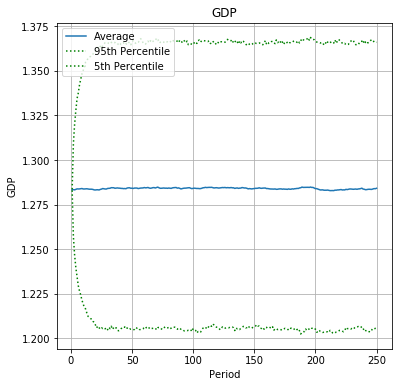

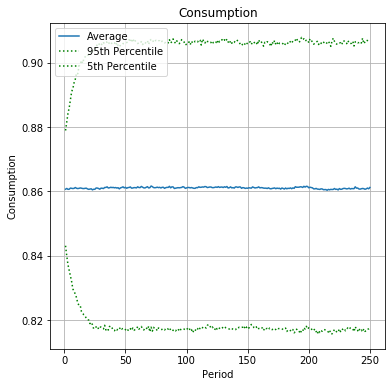

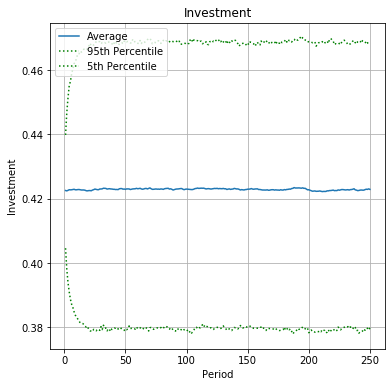

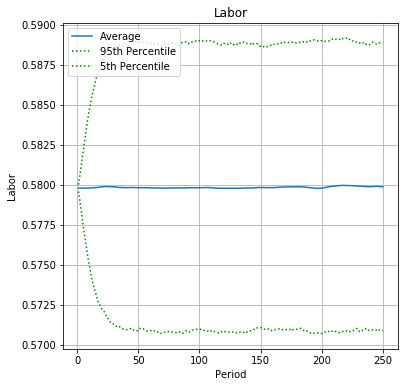

In [31]:
def plot_series(title, series):
    fig = plt.figure(figsize=(6,6))
    x = np.arange(1, 251, 1)
    q95 = np.percentile(series, 95, axis=0)
    q5 = np.percentile(series, 5, axis=0)
    av = np.mean(series, axis=0)
    plt.plot(x, av, label='Average')
    plt.plot(x, q95, 'g:', label='95th Percentile')
    plt.plot(x, q5, 'g:', label='5th Percentile')
    plt.xlabel('Period')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_series('GDP', GDP)
plot_series('Consumption', consumption)
plot_series('Investment', investment)
plot_series('Labor', laborInc)

## Exercise 8

In [32]:
numSims = 10000
numPeriods = 250

average = np.empty((4,numSims))
dev = np.empty((4,numSims))
cv = np.empty((4,numSims))
relvol = np.empty((4,numSims))
autocorrelation = np.empty((4,numSims))
cyclic = np.empty((4,numSims))
    
series = [GDP, consumption, investment, laborInc]

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

for index, s in enumerate(series):
    average[index, :] = np.mean(s)
    dev[index, :] = np.std(s)
    cv[index, :] = means[index, :] / volatility[index, :]
    relvol[index, :] = volatility[index, :] / np.std(GDP)
    for index1 in range(numSims):
        tempSeries = pd.Series(s[index1, :])
        autocorrelation[index, index1] = tempSeries.autocorr(1)
        cyclic[index, index1] = stats.pearsonr(s[index1, :], GDP[index1, :])[0]

NameError: name 'means' is not defined

In [ ]:
names = np.array(['GDP', 'Consumption', 'Investment', 'Labor'])
for index, name in enumerate(names):
    print(name)
    print('Mean = ', np.mean(average[index, :]), '\nStandard Error = ', stats.sem(average[index, :]))
    print('Volatility =  ', np.mean(dev[index, :]), '\nStandard Error = ', stats.sem(dev[index, :]))
    print('Coefficient of Variation = ', np.mean(cv[index, :]), '\nStandard Error = ', stats.sem(cv[index, :]))
    print('Relative Volatility = ', np.mean(relvol[index, :]), '\nStandard Error = ', stats.sem(relvol[index, :]))
    print('Persistence = ', np.mean(autocorrelation[index, :]), '\nStandard Error = ', stats.sem(autocorrelation[index, :]))
    print('Cyclicality = ', np.mean(cyclic[index, :]), '\nStandard Error = ', stats.sem(cyclic[index, :]))
    print('____________________________________________________________')
    print('\n')

## Exercise 9

In [ ]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
rho_z = 0.9
tau = 0.05
mu_z = 0
sigma_z = 0.02
numPeriods = 50

X_bar = np.array([[kbar],[ellbar]])
Z_bar = 0

# Store exogenous variable
Z_tilde = np.zeros(numPeriods + 1)
# Store endogenous variables: capital and labor
X_tilde = np.zeros((2, numPeriods + 1))
# Generate sequence of shocks
#eps = np.random.normal(loc=mu_z, scale=sigma_z, size=numPeriods)
eps = np.zeros(numPeriods + 1)
#lag = 40
eps[0] = sigma_z
# Clear memory
X = np.empty_like(X_tilde)
Z = np.empty_like(Z_tilde)

for tt in range(1, numPeriods + 1):
    # Update Z
    Z_tilde[tt] = NN * (Z_tilde[tt-1]) + eps[tt-1]
    # Get last period's X variables
    X_t_minus1 = np.array([X_tilde[:,tt-1]]).T
    # Update X
    X_tilde[:,tt] = (np.dot(PP, X_t_minus1) + QQ *(Z_tilde[tt])).T

# Convert to actual levels
X = X_bar * np.exp(X_tilde)
Z = Z_tilde + Z_bar

# Store variables
# Capital today and tomorrow
capital = X[0,:-1]
capital1 = X[0,1:]
# Labor
laborIn = X[1, 1:]
# Z
shocks = Z[:-1]
# GDP = Y
GDP = (capital**alpha) * (((np.exp(shocks) * laborIn)** (1 - alpha)))
# Investment
investment = capital1 - (1 - delta) * capital
# Wage
wage = (1-alpha) * np.exp(shocks) * ((capital / (laborIn * np.exp(shocks))) ** alpha)
# Rent
rent = alpha * ((laborIn * np.exp(shocks) / capital) ** (1 - alpha))
# Consumption
consumption = (wage * laborIn + (rent - delta) * capital) + capital - capital1

In [ ]:
names = np.array(['GDP', 'Consumption', 'Investment', 'Labor'])
series = [GDP, consumption, investment, laborIn]

for index, s in enumerate(series):
    periods = np.linspace(1, numPeriods + 1, numPeriods)
    plt.plot(periods, s[:numPeriods], 'k--')
    plt.xlabel('Time')
    plt.ylabel(names[index])
    plt.title('Impuse response of %s' %names[index])
    plt.grid()
    plt.show()

## Exercise 10

In [ ]:
# Parameters
alpha = .35
beta = .96 ** 20
delta = 1 - (1 - .05) ** 20
sigma = 3
A = 1
z_bar = 0
rho_z = 0.9 ** 20
nvec = np.array([1, 1, .2])
length = 3
T = 30

params = alpha, beta, delta, sigma, nvec, A

In [ ]:
def get_w(K, Z , w_args):
    '''This function calculates the equilibrium wage given a level
    of aggregate capital and model parameters.'''
    A, alpha = w_args
    
    w = (1 - alpha) * A * np.exp(Z) * (((K) / (2.2)) ** alpha)
    
    return w

def get_r(K, Z, r_args):
    '''This function calculates the equilibrium interest rate given a level
    of aggregate capital and model parameters..'''
    A, alpha, delta = r_args
    
    r = alpha * A * np.exp(Z) * ((2.2 / (K)) ** (1 - alpha)) - delta
    
    return r

In [ ]:
def Modeldyn_OG(theta0, params):
    
    
    (k2pp, k3pp, k2p, k3p, k2, k3, Zp, Z) = theta0
    
    
    alpha, beta, delta, sigma, nvec, A = params
    w_args = A, alpha
    r_args = A, alpha, delta
    
    
    K = k2 + k3
    
    Kp = k2p + k3p
    
    r = get_r(K, Z, r_args)
    rp = get_r(Kp, Zp, r_args)
    
    w = get_w(K, Z, w_args)
    wp = get_w(Kp, Zp, w_args)
    
    
    c1 = nvec[0] * w - k2p
    c2 = nvec[1] * w + (1 + r) * k2 - k3p
    c2p = nvec[1] * wp + (1 + rp) * k2p - k3pp
    c3p = (1 + rp) * k3p + nvec[2] * wp
    
    
    MU1 = c1 ** (-sigma)
    MU2 = c2 ** (-sigma)
    MU2p = c2p ** (-sigma)
    MU3p = c3p ** (-sigma)
    
    
    err1 = MU1 - beta * (1 + rp) * MU2p
    err2 = MU2 - beta * (1 + rp) * MU3p
    
    
    return np.array([err1, err2])

In [ ]:
# set LinApp parameters
Zbar = np.array([z_bar])
nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 0

In [ ]:
# take a guess for steady state values of kbar2 and kbar3
guessXY = np.array([.05, .05])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn_OG, params, guessXY, Zbar, nx, ny)
(kbar2, kbar3) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar2, kbar3, kbar2, kbar3, kbar2, kbar3, 0., 0.])

# check SS solution
check = Modeldyn_OG(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
    
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn_OG, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho_z
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ:', QQ)


In [ ]:
K_SS = np.array([[kbar2],[kbar3]])
K_tilde = np.zeros((2, T))
# Initial Conditions (need to convert to levels)
K_tilde[0,0] = np.log(0.8 * kbar2) - np.log(kbar2)
K_tilde[1,0] = np.log(1.1 * kbar3) - np.log(kbar3)

# Generate Agg Capital path
for tt in range(1, T):
    K_tilde[:,tt] = (PP @ K_tilde[:,tt-1])
K = K_SS * np.exp(K_tilde)
K_TPI = np.sum(K, axis=0)

# Generate wage and capital paths
w_args = A, alpha
r_args = A, alpha, delta
rpath = get_r(K_TPI, np.zeros(T), r_args)
wpath = get_w(K_TPI, np.zeros(T), w_args)

In [ ]:
plt.plot(K_TPI, label='Aggregate Capital Stock')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Eqm time profile of aggregate capital')
plt.legend()
plt.show()

plt.plot(rpath, label='Interest Rate')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Eqm time profile of interest rate')
plt.legend()
plt.show()

plt.plot(wpath, label='Wage')
plt.xlabel('Time')
plt.ylabel('Level')
plt.grid()
plt.title('Eqm time profile of wage')
plt.legend()
plt.show()

# Perturbation Methods (Question 1 is in the pdf file)

## Exercise 2

In [ ]:
alpha = .33
z = 1
b = 2
t = .1
h = 24

In [ ]:
def mkt_wage(w, *p):
    alpha, z, b, t, h, k = p
    nd = (((1 - alpha)* z) / w) ** (1 / alpha) * k
    pi = z * k ** alpha * (nd) ** (1 - alpha) - w * nd
    ns = h - (b / (w * (1 + b))) * (w * h + pi - t)
    return nd - ns

In [ ]:
k = 5
params = alpha, z, b, t, h, k
equi_w = opt.fsolve(mkt_wage, 0.5, args=params)
equi_w

In [ ]:
kGrid = np.arange(1, 16, 1)
wageGrid = np.zeros(len(kGrid))
for ii in range(len(kGrid)):
    params = alpha, z, b, t, h, kGrid[ii]
    wageGrid[ii] = opt.fsolve(mkt_wage, .1, args=params)

In [ ]:
# First order approximation
def first_order_k(k, params, eps, wageGrid, kGrid):
    alpha, z, b, t, h, = params
    argsminus = alpha, z, b, t, h, (k - eps)
    argsplus = alpha, z, b, t, h, (k + eps)
    
    wminus = opt.fsolve(mkt_wage, 0.5, args=argsminus)
    wplus = opt.fsolve(mkt_wage, 0.5, args=argsplus)
    
    # Central difference
    xu = (wplus - wminus)/(2 * eps)
    wage_k = wageGrid[kGrid == k] + xu * (kGrid - k)

    return wage_k

In [ ]:
params = alpha, z, b, t, h
eps = 1e-5

wage_5 = first_order_k(5, params, eps, wageGrid, kGrid)
wage_10 = first_order_k(10, params, eps, wageGrid, kGrid)

In [ ]:
# Second order approximation
def second_order_k(k, params, eps, wageGrid, kGrid):
    
    alpha, z, b, t, h, = params
    argsminus = alpha, z, b, t, h, (k - eps)
    argsplus = alpha, z, b, t, h, (k + eps)
    args = alpha, z, b, t, h, k
    
    wminus = opt.fsolve(mkt_wage, 0.5, args=argsminus)
    wplus = opt.fsolve(mkt_wage, 0.5, args=argsplus)
    w = opt.fsolve(mkt_wage, 0.5, args=args)
        
    xu = (wplus - wminus)/(2 * eps)
    # Use forward and backward differences to get second derivative
    xuu = (wplus - 2 * w + wminus) / (eps ** 2)
     
    wage_k = wageGrid[kGrid == k] + xu * (kGrid - k) + 0.5 * xuu * (kGrid - k) ** 2
    
    return wage_k

In [ ]:
params = alpha, z, b, t, h
eps = 1e-5

wage_5_second = second_order_k(5, params, eps, wageGrid, kGrid)
wage_10_second = second_order_k(10, params, eps, wageGrid, kGrid)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(kGrid, wageGrid, label='Grid Solution')
ax[0].plot(kGrid, wage_5, label='FOA')
ax[0].plot(kGrid, wage_5_second, label='SOA')
ax[0].set_xlabel('Capital')
ax[0].set_ylabel('Equilibrium Wage')
ax[0].legend()
ax[0].set_title(r'Approximation around $K=5$')

ax[1].plot(kGrid, wageGrid, label='Grid Solution')
ax[1].plot(kGrid, wage_10, label='FOA')
ax[1].plot(kGrid, wage_10_second, label='SOA')
ax[1].set_xlabel('Capital')
ax[1].set_ylabel('Equilibrium Wage')
ax[1].legend()
ax[1].set_title(r'Approximation around $K=10$')

plt.suptitle('Approximations to Equilibrium Wage')
plt.show()

## Exercise 3

In [35]:
xGrid = np.linspace(99, 101, 50)

In [36]:
def Func(y, *x):
    x = x[0]
    return (x ** .35 + .9 * x - y) ** -2.5 - .95 * (y **.35 + .9 * y) ** -2.5

In [37]:
eps = .01
xzero = 100
xplus1 = opt.fsolve(Func, 50, args=xzero + eps)
xminus1 = opt.fsolve(Func, 50, args=xzero - eps)
xplus2 = opt.fsolve(Func, 50, args=xzero + 2 * eps)
xminus2 = opt.fsolve(Func, 50, args=xzero - 2 * eps)
xcenter = opt.fsolve(Func, 50, args=xzero)
xu = (xplus1 - xminus1) / (2 * eps)
xuu = (xplus1 - 2 * xcenter + xminus1) / (eps ** 2)
xuuu = (xplus2 - 2 * xplus1 + 2 * xminus1  - xminus2) / (2 * eps ** 3)

# Approximations
linear = xcenter + xu * (xGrid - xzero)
quad = xcenter + xu * (xGrid - xzero) + (.5) * xuu * (xGrid - xzero) ** 2
cubic = xcenter + xu * (xGrid - xzero) + (.5) * xuu * (xGrid - xzero) ** 2 + (1.0/6) * xuuu * (xGrid - xzero) ** 3

# Grid solution
gridSol = np.zeros(len(xGrid))
for ii in range(len(xGrid)):
    gridSol[ii] = opt.fsolve(Func, 50, args=xGrid[ii])  

In [38]:
gridSol = np.zeros(len(xGrid))
for i in range(len(xGrid)):
    gridSol[i] = opt.fsolve(Func, 50, args=xGrid[ii])  

In [39]:
xu

array([0.4710853])

In [40]:
xuu * .5

array([-6.5972117e-06])

In [41]:
xuuu * (1/6)

array([3.6119256e-08])

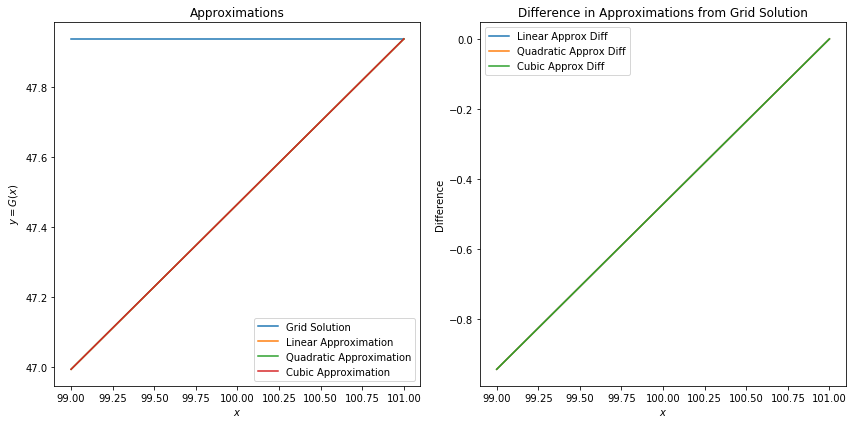

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
# Plot approximations
ax[0].plot(xGrid, gridSol, label='Grid Solution')
ax[0].plot(xGrid, linear, label='Linear Approximation')
ax[0].plot(xGrid, quad, label='Quadratic Approximation')
ax[0].plot(xGrid, cubic, label='Cubic Approximation')
ax[0].legend()
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y = G(x)$')
ax[0].set_title('Approximations')

# Plot the difference between the linear, quadratic and cubic approximations and the grid solution
ax[1].plot(xGrid, linear - gridSol, label='Linear Approx Diff')
ax[1].plot(xGrid, quad - gridSol, label='Quadratic Approx Diff')
ax[1].plot(xGrid, cubic - gridSol, label='Cubic Approx Diff')
ax[1].legend()
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'Difference')
ax[1].set_title('Difference in Approximations from Grid Solution')

plt.tight_layout()
plt.show()

## Exercise 4

In [44]:
kbar = (m.alpha * m.beta) ** (1 / (1 - m.alpha))
u = sy.Symbol('u') # K_t
x = sy.Function('x')(u) # x is a function of u, K_{t+1}
y = sy.Function('y')(u) # y is a functino of u, K_{t+2}
xu = sy.Symbol('xu') 
xuu = sy.Symbol('xuu')

In [45]:
F = (1 / (u ** m.alpha - x)) - ((m.beta * m.alpha * x ** (m.alpha - 1)) / (x ** m.alpha - y))

dFu = sy.diff(F, u)
dFuSubs = dFu.subs([(sy.diff(x, u), xu), (sy.diff(y, u), xu ** 2), (y, kbar), (x, kbar), (u, kbar)])
xu = float(solve(dFuSubs)[0])
dFuu = sy.diff(F, u, 2)
dFuuSubs = dFuu.subs([(sy.diff(y, u, 2), (xu + xu ** 2) * xuu), (sy.diff(x, u, 2), xuu), 
                      (sy.diff(y, u), xu ** 2), (sy.diff(x, u), xu), 
                      (y, kbar), (x, kbar), (u, kbar)])

xuu = float(solve(dFuuSubs)[0])

In [47]:
def analytic(m, k):
    return m.alpha * m.beta * (k ** m.alpha)

def linear(k, kbar, xu):
    return kbar + kbar * xu * ((k - kbar) / kbar) 

def quadratic(k, kbar, xu, xuu):
    return kbar + kbar * xu * ((k - kbar) / kbar) + 0.5 * xuu * ((k - kbar) / kbar) ** 2 

kGrid = np.linspace(0.5 * kbar, 1.5 * kbar, 50)

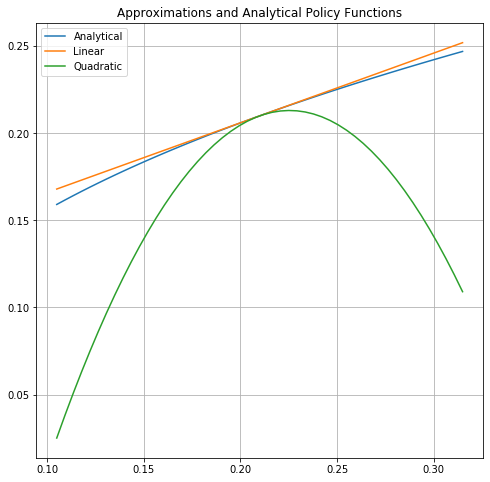

In [49]:
fig = plt.figure(figsize=(8, 8))
plt.plot(kGrid, analytic(m, kGrid), label='Analytical')
plt.plot(kGrid, linear(kGrid, kbar, xu), label='Linear')
plt.plot(kGrid, quadratic(kGrid, kbar, xu, xuu), label='Quadratic')
plt.grid()
plt.title('Approximations and Analytical Policy Functions')
plt.legend()
plt.show()